# Coherent noise

In [1]:
import numpy as np
from tqdm import tqdm

from evolution import Evolve_ob, Evolve_state
from metric import state_alg_err
from qiskit.quantum_info import SparsePauliOp, Statevector, random_statevector

from quantum_simulation_recipe.trotter import pf, expH
from quantum_simulation_recipe.plot_config import *
from quantum_simulation_recipe.bounds import tight_bound
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
# from observable_decay import Evolve_ob, Evolve_state

good_color_cycle = ['#9467bdFF', '#2ca02cFF', '#d62728FF', '#1f77b4FF', '#ff7f0eFF', '#8c564bFF', '#e377c2FF', '#7f7f7fFF', '#bcbd22FF', '#17becfFF']
set_color_cycle(good_color_cycle)

mpl.rcParams['legend.frameon'] = False
# mpl.rcParams['font.family'] = 'sans-serif' # 'Helvetica' 'sans-serif'  
fig_dir, data_dir = './figs', './data'

## Analog

In [9]:
SparsePauliOp.from_sparse_list([('X', [i], np.random.normal(0, 1)) for i in range(0, 8)], 8)

SparsePauliOp(['IIIIIIIX', 'IIIIIIXI', 'IIIIIXII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'],
              coeffs=[ 0.391944+0.j,  0.229598+0.j,  1.061826+0.j,  1.412108+0.j, -0.577346+0.j,
  0.583295+0.j,  1.4638  +0.j, -0.65115 +0.j])

In [15]:
Statevector.from_label('0'*2).data

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

+++++++++++++++++++++++++++++++++++++++++++++++++++

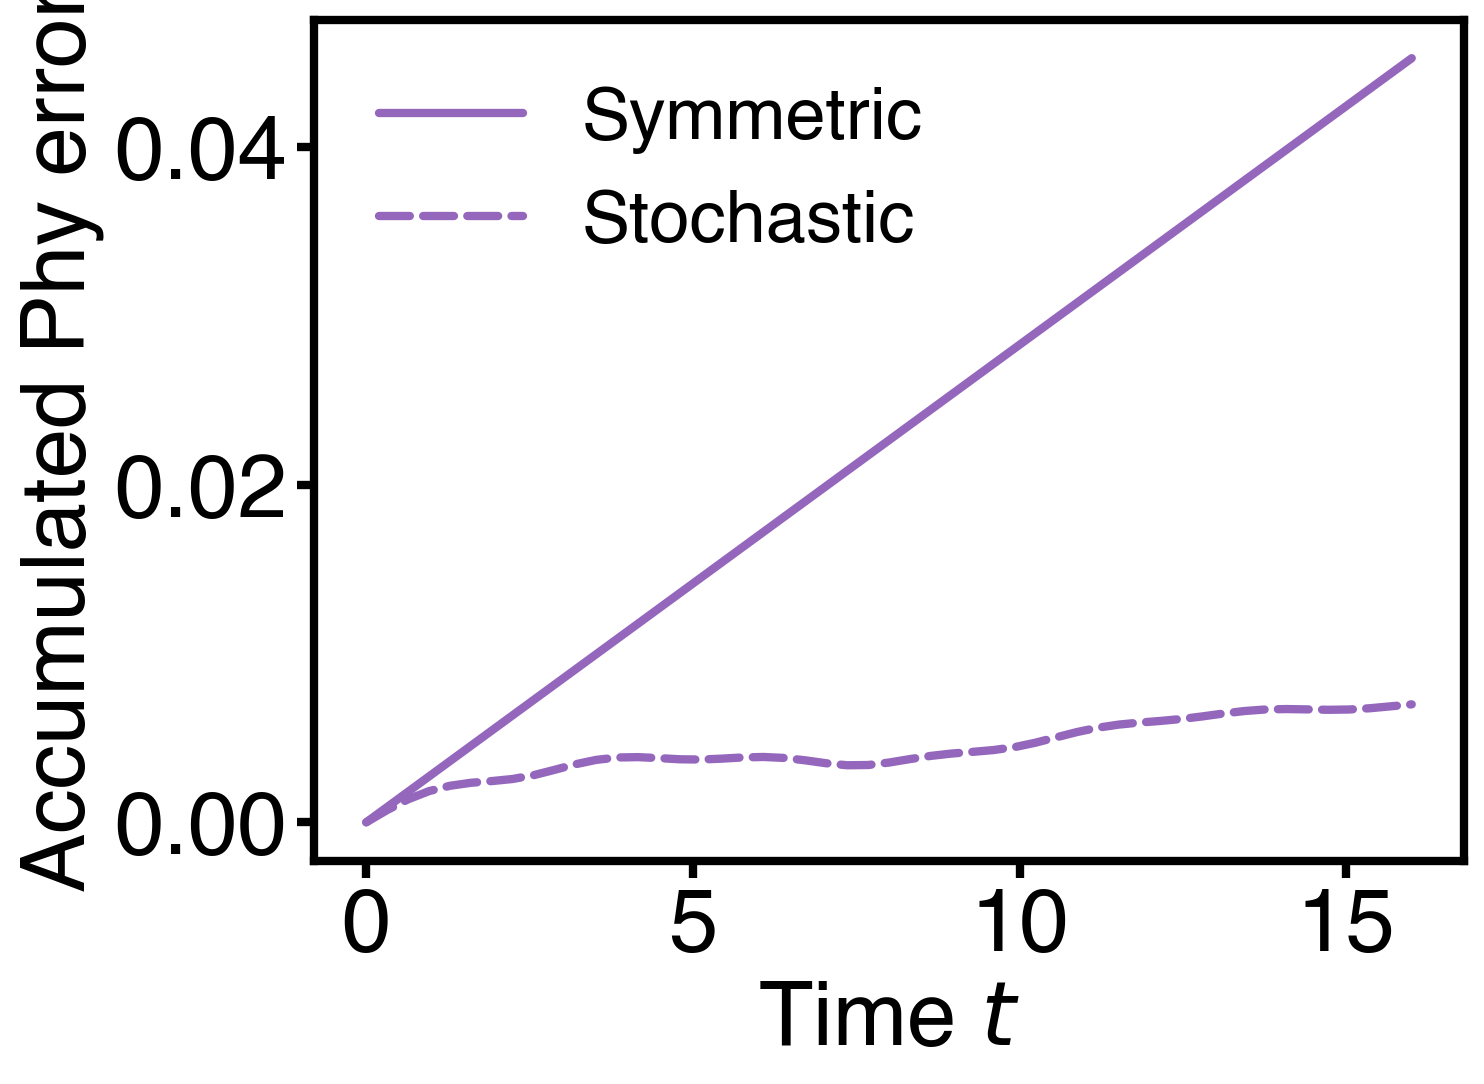

In [8]:
n = 8 # system size could be 4, 6, 8, 10, 12 ...
t, r = 2*n, 50
t_list = np.linspace(0, t, r+1)  # time steps

J, h, pbc = 0.2*np.pi, 2*np.pi, True
g = 0.001
H_model_par = {'Jz': J, 'hx': h, 'pbc': pbc, 'group': 'xyz'}
nnh_ideal = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, pbc=pbc)
nnh_sym = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h+g, pbc=pbc)
nnh_sto = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, pbc=pbc)
# generate gaussian $n$ random variables a_j with mean 0 and std g
# for each site j, add a X_j operator with coefficient a_j
nnh_sto.ham += SparsePauliOp.from_sparse_list([('X', [i], np.random.normal(0, g)) for i in range(0, n)], n)  # add disorder
ob = SparsePauliOp.from_sparse_list([('Y', [1], 1)], n).to_matrix()  # observable to measure

## exact and trotter (approximate) evolution
st_err_sym, st_err_sto = [], []
ob_err_sym, ob_err_sto = [], []

## the initial state
state_0 = Statevector.from_label('0'*n).data

for t in t_list:
    print('+', end='')
    U_ext = expH(nnh_ideal.ham, t)
    U_sym = expH(nnh_sym.ham, t)
    U_sto = expH(nnh_sto.ham, t)
    st_ext = U_ext @ state_0
    st_sym = U_sym @ state_0
    st_sto = U_sto @ state_0

    st_err_sym.append(np.linalg.norm(st_ext - st_sym))
    st_err_sto.append(np.linalg.norm(st_ext - st_sto))

    expval_ext = st_ext.conjugate().T @ ob @ st_ext
    expval_sym = st_sym.conjugate().T @ ob @ st_sym
    expval_sto = st_sto.conjugate().T @ ob @ st_sto

    ob_err_sym.append(abs(expval_ext - expval_sym))
    ob_err_sto.append(abs(expval_ext - expval_sto)) 

set_fontsize(medium=MEDIUM_SIZE+8, large=LARGE_SIZE+8, linewidth=3.0)
fig, axes['A'] = plt.subplots()
# fig, axes = plt.subplot_mosaic(
#     """
#     AB
#     """, constrained_layout=True, sharex=True, figsize=(12, 6))
# gc = GradColors(gamma_num)
# cm_phy, cm_alg, cm_tot, cm_acc, cm_pur, cm_ent = gc.purple, gc.red, gc.green, gc.blue, gc.orange, gc.mint

axes['A'].plot(t_list, st_err_sym, '-', label='Symmetric', color=good_color_cycle[0], lw=3)
axes['A'].plot(t_list, st_err_sto, '--', label='Stochastic', color=good_color_cycle[0], lw=3)
axes['A'].set_xlabel(rf'Time $t$')
axes['A'].set_ylabel('Accumulated Phy error')
# axes['B'].set_ylabel('Accumulated Alg error')
# axes['A'].set_ylabel('Expectation/state Error')
axes['A'].legend()
fig.savefig(f'{fig_dir}/coherent_noise_state_error_n={n}.pdf', bbox_inches='tight')


## Trotter+coherent noise

In [201]:
# np.std([np.random.normal(0, g) for _ in range(n)])
[np.random.normal(0, g) for _ in range(n)]

[-0.0028058225266681946,
 0.0005876985155001365,
 -0.005232932234494047,
 -0.014014432814017526,
 -0.016366324772664878,
 -0.00169433583598254,
 0.007916289102053161,
 -0.011775774563517544]

In [29]:
from states import random_states
# rnd_input = random_states(n, 20, verbose=False)
# nnh_sto_list[0].ham
print(nnh_sym.ham_xyz)
print(nnh_ide.ham_xyz)
print((nnh_sym.ham-nnh_ide.ham).simplify())

[SparsePauliOp(['IIIIIIIIXX', 'IIIIIIIXXI', 'IIIIIIXXII', 'IIIIIXXIII', 'IIIIXXIIII', 'IIIXXIIIII', 'IIXXIIIIII', 'IXXIIIIIII', 'XXIIIIIIII', 'XIIIIIIIIX', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j,
 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j]), SparsePauliOp(['IIIIIIIIYY', 'IIIIIIIYYI', 'IIIIIIYYII', 'IIIIIYYIII', 'IIIIYYIIII', 'IIIYYIIIII', 'IIYYIIIIII', 'IYYIIIIIII', 'YYIIIIIIII', 'YIIIIIIIIY'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j]), SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZZI', 'IIIIIIZZII', 'IIIIIZZIII', 'IIIIZZIIII', 'IIIZZIIIII', 'IIZZIIIIII', 'IZZIIIIIII', 'ZZIIIIIIII', 'ZIIIIIIIIZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5

In [51]:
U_dt_ide
# U_dt_sym
np.array(H_list_ide)-np.array(H_list_sym)
assert np.allclose(H_list_ide, H_list_sym)
# assert np.allclose(U_dt_ide, U_dt_sym)

SparsePauliOp(['IIIIIIIIXX', 'IIIIIIIXXI', 'IIIIIIXXII', 'IIIIIXXIII', 'IIIIXXIIII', 'IIIXXIIIII', 'IIXXIIIIII', 'IXXIIIIIII', 'XXIIIIIIII', 'XIIIIIIIIX', 'IIIIIIIIYY', 'IIIIIIIYYI', 'IIIIIIYYII', 'IIIIIYYIII', 'IIIIYYIIII', 'IIIYYIIIII', 'IIYYIIIIII', 'IYYIIIIIII', 'YYIIIIIIII', 'YIIIIIIIIY', 'IIIIIIIIZZ', 'IIIIIIIZZI', 'IIIIIIZZII', 'IIIIIZZIII', 'IIIIZZIIII', 'IIIZZIIIII', 'IIZZIIIIII', 'IZZIIIIIII', 'ZZIIIIIIII', 'ZIIIIIIIIZ', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 1. +0.j, 1. +0.j,
 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j])


100%|██████████| 50/50 [00:04<00:00, 10.81it/s]


[0.010841603, 0.02196316, 0.030407026, 0.03259346, 0.028892266, 0.023568107, 0.020619407, 0.021335432, 0.025584726, 0.032741252, 0.03918438, 0.0407766, 0.03705794, 0.032534886, 0.032255217, 0.0340609, 0.036893517, 0.043605592, 0.0494787, 0.04917419, 0.04408209, 0.04073858, 0.042060975, 0.044695076, 0.047400393, 0.05201112, 0.05688948, 0.057746872, 0.05411998, 0.050654326, 0.05122708, 0.05395342, 0.05734915, 0.06178205, 0.06509221, 0.064819224, 0.062619574, 0.06148758, 0.062570535, 0.06516497, 0.06826383, 0.07138974, 0.07352606, 0.07350012, 0.07236495, 0.07262312, 0.07488474, 0.077886984, 0.08127353, 0.08469006]


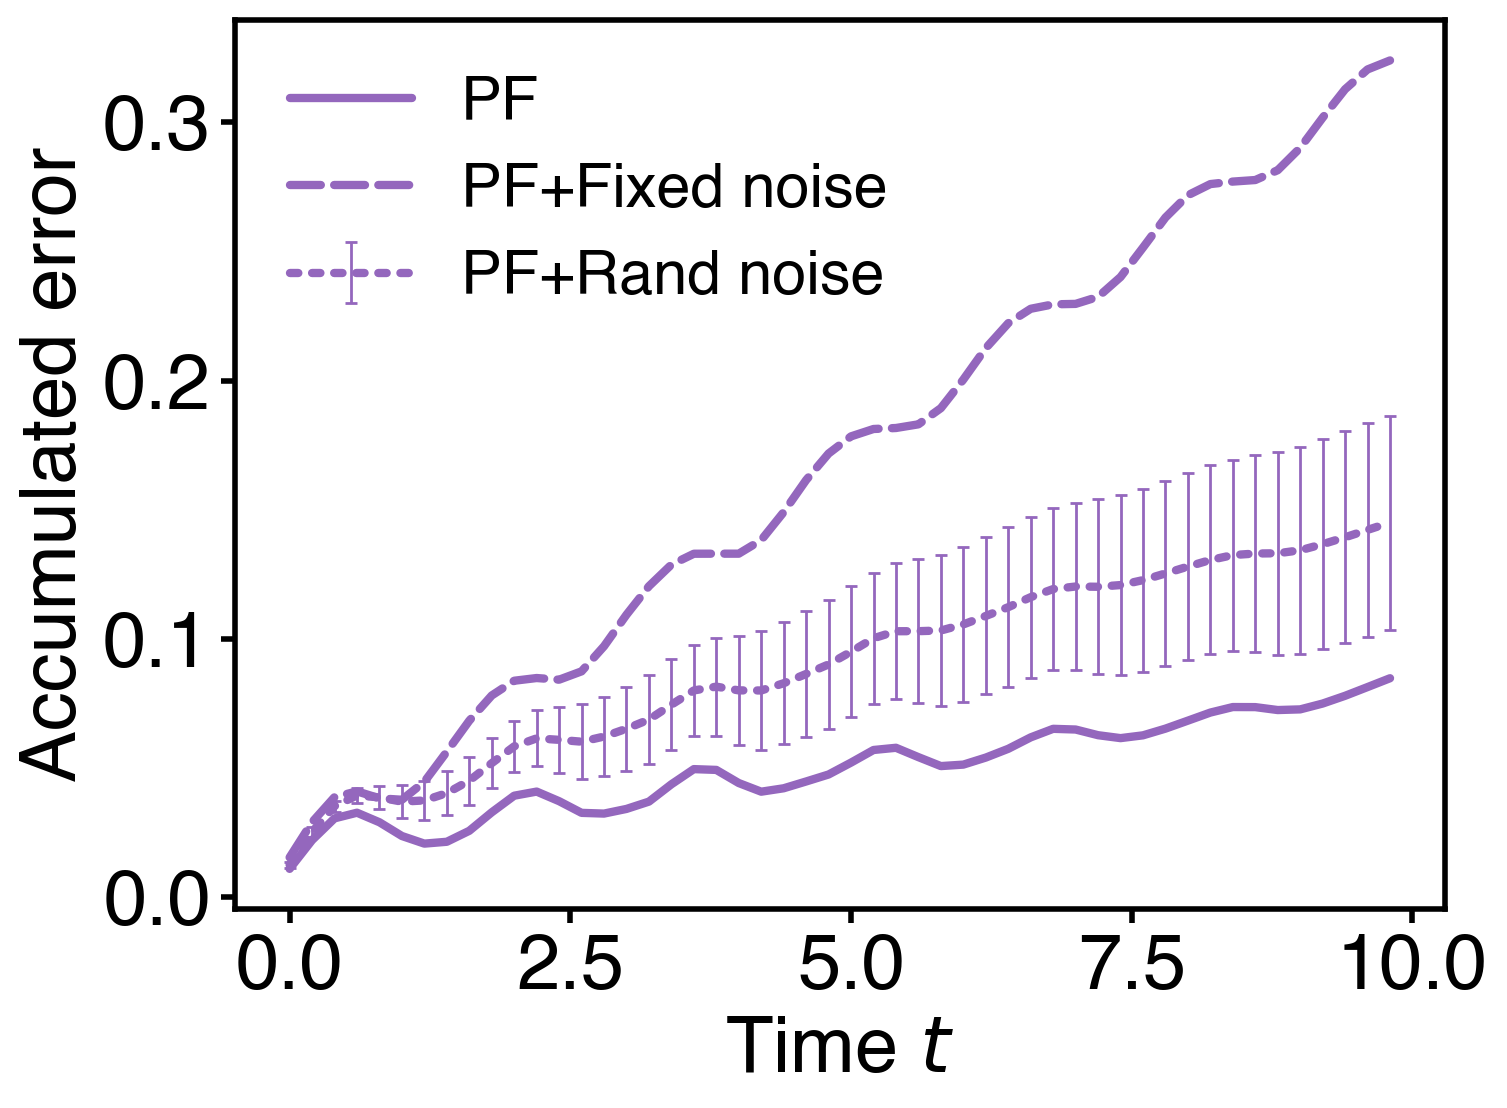

In [60]:
# n = 10 # system size could be 4, 6, 8, 10, 12 ...
n = 10 # system size could be 4, 6, 8, 10, 12 ...
t, r = n, 50
dt = t/r
t_list = np.arange(0, r)  * dt
n_rand = 100  # number of random stochastic noise realizations
# t_list = np.linspace(0, t, r+1)  # time steps

J, h, pbc = 0.5, 1, True
g = 0.01
# g = 0.0001
H_model_par = {'Jz': J, 'hx': h, 'pbc': pbc, 'group': 'xyz'}
nnh_ide = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, pbc=pbc)
nnh_sym = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h+g, pbc=pbc)
# nnh_sto = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, pbc=pbc, rand_field=[np.random.normal(0, g) for _ in range(n)])
nnh_sto_list = [Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, pbc=pbc, rand_field=[np.random.normal(0, g) for _ in range(n)]) for _ in range(n_rand)]
# nnh_sto = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, pbc=pbc)
# generate gaussian $n$ random variables a_j with mean 0 and std g
# for each site j, add a X_j operator with coefficient a_j
# nnh_sto.ham += SparsePauliOp.from_sparse_list([('X', [i], np.random.normal(0, g)) for i in range(0, n)], n) 
# ob = SparsePauliOp.from_sparse_list([('Y', [1], 1)], n).to_matrix()  # observable to measure
print(nnh_ide.ham)
# print(nnh_sto.ham)

# H_list = [term.to_matrix() for term in nnh.ham_par]
p_pf = 2
H_list_ide = [term.to_matrix() for term in nnh_ide.ham_xyz]
H_list_sym = [term.to_matrix() for term in nnh_sym.ham_xyz]
# H_list_sto = [term.to_matrix() for term in nnh_sto.ham_xyz]
H_list_sto_list = [[term.to_matrix() for term in nnh.ham_xyz] for nnh in nnh_sto_list]
U_dt_ide = pf(H_list_ide, dt, 1, order=p_pf, use_jax=True)  # use_jax to avoid n>8 issue with numpy
U_dt_sym = pf(H_list_sym, dt, 1, order=p_pf, use_jax=True)
# U_dt_sto = pf(H_list_sto, dt, 1, order=p_pf)
U_dt_sto_list = [pf(H_list, dt, 1, order=p_pf, use_jax=True) for H_list in H_list_sto_list]
U_dt_ext = expH(sum(H_list_ide), dt)

## exact and trotter (approximate) evolution
# phy_st_err_sym, phy_st_err_sto = [], []
st_err_ide, st_err_sym, st_err_sto = [], [], []
st_err_sto_list = [[] for _ in range(n_rand)]
# alg_st_err_sym, alg_st_err_sto = [], []
# ob_err_sym, ob_err_sto = [], []

## the initial state
st_0 = Statevector.from_label('0'*n).data
st_ext, st_ide, st_sym, st_sto = st_0, st_0, st_0, st_0
st_sto_list = [st_0 for _ in range(n_rand)]  

for i in tqdm(range(len(t_list))):
# for i, t in enumerate(t_list):
    st_ext = U_dt_ext @ st_ext
    st_ide = U_dt_ide @ st_ide
    st_sym = U_dt_sym @ st_sym
    # st_sto = U_dt_sto @ st_sto

    st_err_ide.append(np.sqrt(1-abs(st_ide.conjugate().T @ st_ext)**2))
    st_err_sym.append(np.sqrt(1-abs(st_sym.conjugate().T @ st_ext)**2))
    for j in range(n_rand):
        st_sto_list[j] = U_dt_sto_list[j] @ st_sto_list[j]
        st_err_sto_list[j].append(np.sqrt(1-abs(st_sto_list[j].conjugate().T @ st_ext)**2))

    # st_err_sto.append(np.sqrt(1-abs(st_sto.conjugate().T @ st_ext)**2))
# print(st_err_sto)
print(st_err_ide)

set_fontsize(medium=MEDIUM_SIZE+4, large=LARGE_SIZE+4, linewidth=2.0)
fig, ax = plt.subplots()

ax.plot(t_list, st_err_ide, '-', label='PF', color=good_color_cycle[0], lw=3)
ax.plot(t_list, st_err_sym, '--', label='PF+Fixed noise', color=good_color_cycle[0], lw=3)
# ax.plot(t_list, st_err_sto, ':', label='PF+Rand noise', color=good_color_cycle[0], lw=3)
ax.errorbar(t_list, np.mean(st_err_sto_list, axis=0), yerr=np.std(st_err_sto_list, axis=0), fmt=':', label='PF+Rand noise', color=good_color_cycle[0], lw=3, capsize=2, capthick=1, elinewidth=1)  # capsize=1,, dash_capstyle='round'
ax.set_xlabel(rf'Time $t$')
ax.set_ylabel('Accumulated error')
ax.legend()
fig.savefig(f'{fig_dir}/coherent_noise_Trotter_error_n={n}.pdf', bbox_inches='tight')
# fig.savefig(f'{fig_dir}/coherent_noise_Trotter_error_TFI_n={n}.pdf', bbox_inches='tight')

In [15]:
# st_err_ide 
st_err_sym 
# st_err_sto

[0.023419716983872206,
 0.04906521041845816,
 0.0782412575966923,
 0.11027871895149782,
 0.14260856949895864,
 0.17218781477702266,
 0.1970831278301017,
 0.2176075695035575,
 0.2366274832518149,
 0.2579563394858557,
 0.2835729514611242,
 0.3126214240496335,
 0.34247335930641193,
 0.3699751921105066,
 0.39276100509146805,
 0.4107723574920349,
 0.4267610337326127,
 0.444634492019428,
 0.4665488460424317,
 0.49153419742486726,
 0.516759680625458,
 0.5394784235258078,
 0.5581448451366707,
 0.5730761504069314,
 0.5866530136365836,
 0.6020289515960016,
 0.6207320103812839,
 0.6416249018892989,
 0.6621775236165446,
 0.6802455390472981,
 0.6949636502584398,
 0.7069248531182207,
 0.7179474763587761,
 0.7302178641573467,
 0.744872604468055,
 0.7611523039463836,
 0.7770886672957221,
 0.7909337161906508,
 0.8020062144418041,
 0.8107801668063966,
 0.8186220719277215,
 0.8271725792250901,
 0.8373737091328339,
 0.8488234140667932,
 0.8601138057862879,
 0.8698289039252066,
 0.8773565088336663,
 0.8830

In [ ]:

set_fontsize(medium=MEDIUM_SIZE+8, large=LARGE_SIZE+8, linewidth=3.0)
# fig, ax = plt.subplots()
fig, axes = plt.subplot_mosaic(
    """
    AB
    """, constrained_layout=True, sharex=True, figsize=(12, 6))
# gc = GradColors(gamma_num)
# cm_phy, cm_alg, cm_tot, cm_acc, cm_pur, cm_ent = gc.purple, gc.red, gc.green, gc.blue, gc.orange, gc.mint

axes['A'].plot(t_list, phy_st_err_sym, '-', label='Symmetric', color=good_color_cycle[0], lw=3)
axes['A'].plot(t_list, phy_st_err_sto, '--', label='Stochastic', color=good_color_cycle[0], lw=3)
axes['A'].set_xlabel(rf'Time $t$')
axes['A'].set_ylabel('Accumulated Phy error')
axes['B'].plot(t_list, alg_st_err_sym, '-', label='Symmetric', color=good_color_cycle[2], lw=3)
axes['B'].plot(t_list, alg_st_err_sto, '--', label='Stochastic', color=good_color_cycle[2], lw=3)
axes['B'].set_ylabel('Accumulated Alg error')
# axes['A'].set_ylabel('Expectation/state Error')
axes['A'].legend(); axes['B'].legend()
fig.savefig(f'{fig_dir}/coherent_noise_state_errors_n={n}.pdf', bbox_inches='tight')

## Fixed noise rate

In [5]:
H_model = 'nnh'  # Hamiltonian model
p_pf = 2  # Trotter formula order
n = 8 # system size could be 4, 6, 8, 10, 12 ...
gamma = 5e-3  # noise rate
t, r = n, 100
# t, r = 2*n, 100
dt = t/r
t_list = np.arange(0, r)  * dt

## set Hamiltonian parameters
if H_model == 'nnh':
    J, h, pbc = 2, 1, True
    H_model_par = {'Jz': J, 'hx': h, 'pbc': pbc, 'group': 'xyz'}
    nnh = Nearest_Neighbour_1d(n, Jz=J, hx=h, pbc=pbc)
    # H_list = [term.to_matrix() for term in nnh.ham_par]
    H_list = [term.to_matrix() for term in nnh.ham_xyz]

## exact and trotter (approximate) evolution
U_dt_appro = pf(H_list, dt, 1, order=p_pf)
U_dt_exact = expH(sum(H_list), dt)

## the initial state
state_0 = Statevector.from_label('0'*n).to_operator().to_matrix()

In [21]:
## simulate the evolution in noisy Trotter circuit
n_pf = Evolve_state(U_dt_appro, U_dt_exact, r, state_0, gamma, p_pf, t)

100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


c1=334.48011900835246, c2=167.2400595041763


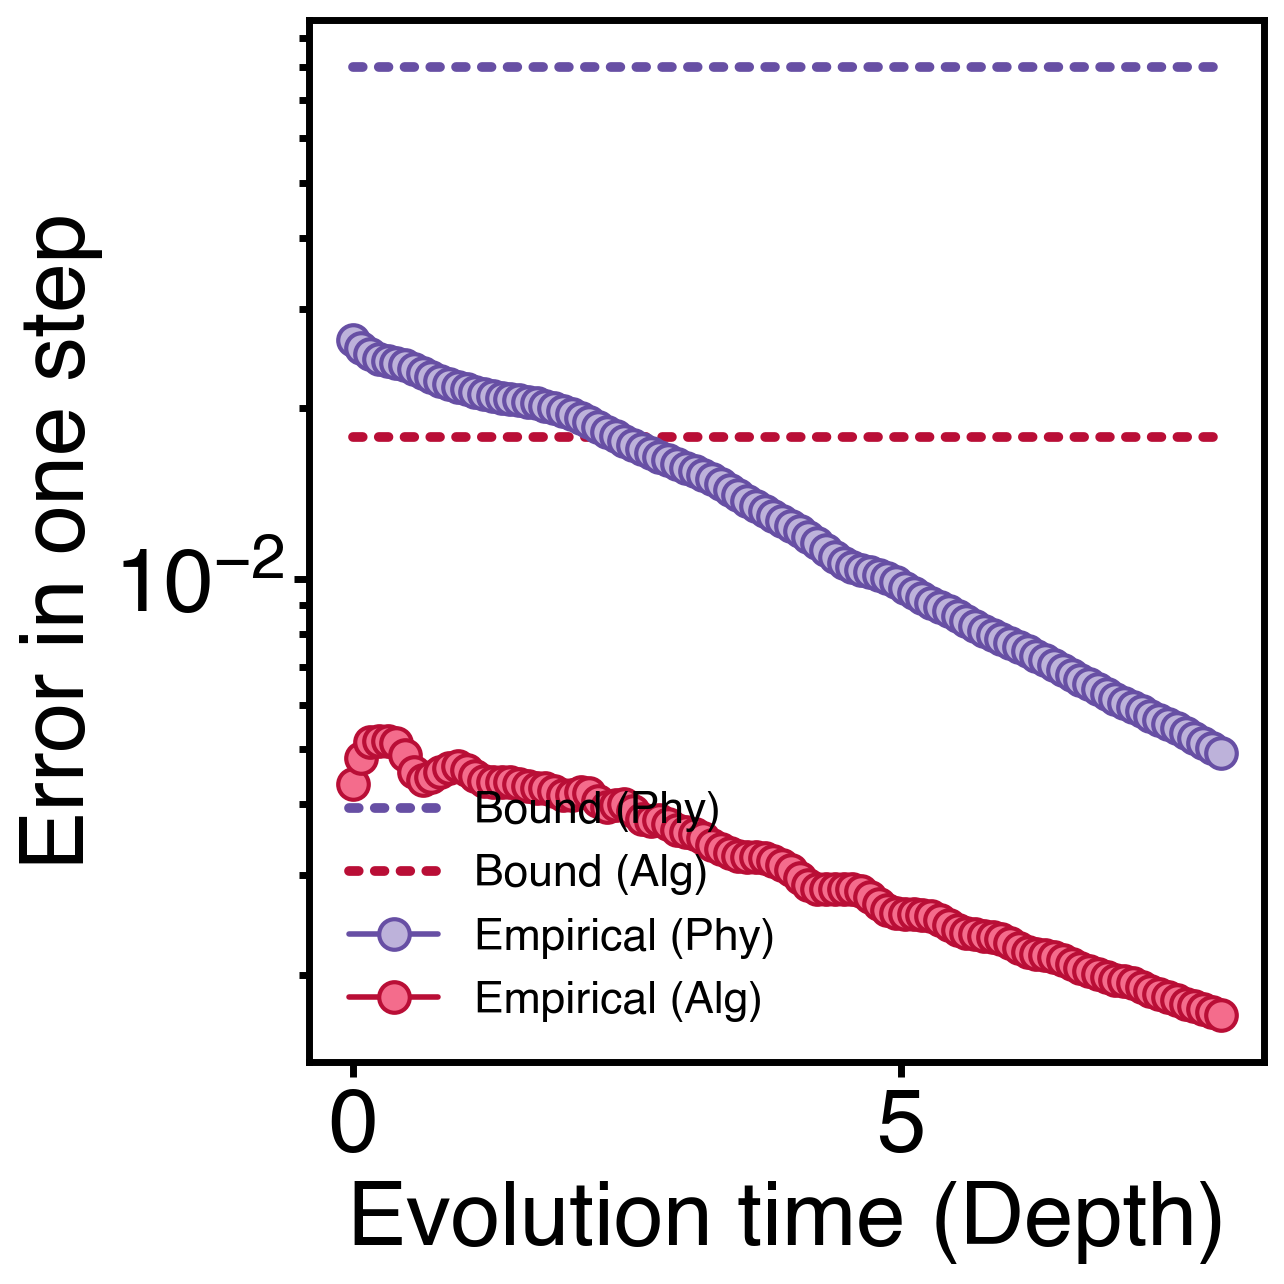

In [23]:
t_list = np.arange(0, r) * dt
set_fontsize(medium=MEDIUM_SIZE+8, large=LARGE_SIZE+8, linewidth=2.5)
plt.rc('legend', fontsize=MEDIUM_SIZE-2) 
gc = GradColors(10)
cm_phy, cm_alg, cm_tot = gc.purple, gc.red, gc.green
gd_idx = 7
phy_plot_color, alg_plot_color, tot_plot_color = cm_phy(gd_idx), cm_alg(gd_idx), cm_tot(gd_idx)
lw_wide = 3.5

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
line1, = plot_evo(ax, t_list, [2*n*gamma]*r, ':', label=f'Bound (Phy)', c=phy_plot_color, lw=lw_wide, return_line=True)
# plot naive alg bnd
naive_alg_bnd = tight_bound(H_list, p_pf, t/r, 1,  verbose=True)
line2, = plot_evo(ax, t_list, [naive_alg_bnd]*r, ':', label=f'Bound (Alg)', c=alg_plot_color, lw=lw_wide, return_line=True)
line3, = plot_evo(ax, t_list, n_pf.phy_err_list, 'o-', label=f'Empirical (Phy)', c=phy_plot_color, lw=2, return_line=True)

line4, = plot_evo(ax, t_list, n_pf.alg_err_list, 'o-', label=f'Empirical (Alg)', c=alg_plot_color, lw=2, return_line=True)

ax_set_text(ax, r'Evolution time $t$ (Depth)', 'Error in one step', log='y')
ax.set_xlabel(r'Evolution time (Depth)', fontweight='bold')
ax.set_ylabel(r'Error in one step', fontweight='bold')

# Create another legend for the second line.
# first_legend = ax.legend(handles=[line1, line3], bbox_to_anchor=(0.30, 0.8), fontsize=22)
# ax.add_artist(first_legend)
# ax.legend(handles=[line2, line4], bbox_to_anchor=(0.30, 0.4), fontsize=22)
ax.legend()
fig.savefig(f'{fig_dir}/illustrate_exp_decay_{H_model}_n={n}_r={r}_gamma={gamma}.pdf', bbox_inches='tight')

## Vary noise rates

In [6]:
## noise range
gamma_num = 6
gamma_min, gamma_max = 0.003, 0.008
gamma_list = np.linspace(gamma_min, gamma_max, num=gamma_num)

In [ ]:
# initialize a dictionary to store the results
phy_errs, alg_errs = {}, {}

# simulate noisy Trotter with different noise rates
for i, gamma in enumerate(gamma_list):
    print(f'noise rate: {gamma:.4f}')
    # n_pf = Evolve_state(U_dt, U_dt_exact, r, state_0, True, p)
    # n_pf = Evolve_state(U_dt, U_dt_exact, r, state_0, p, dt**3)
    n_pf = Evolve_state(U_dt_appro, U_dt_exact, r, state_0, gamma, p_pf, t)
    # store the results in the dictionary
    # data[p] = n_pf
    phy_errs[gamma], alg_errs[gamma] = n_pf.phy_err_list, n_pf.alg_err_list

data = {'phy': phy_errs, 'alg': alg_errs, 'model_par': H_model_par}
np.save(f'{data_dir}/{H_model}_depo_decay_n={n}_t={t}_r={r}_gamma={gamma_min}-{gamma_max}.npy', data)

noise rate: 0.0030
noise rate: 0.0040
noise rate: 0.0050
noise rate: 0.0060
noise rate: 0.0070
noise rate: 0.0080


c1=334.48011900835246, c2=167.2400595041763


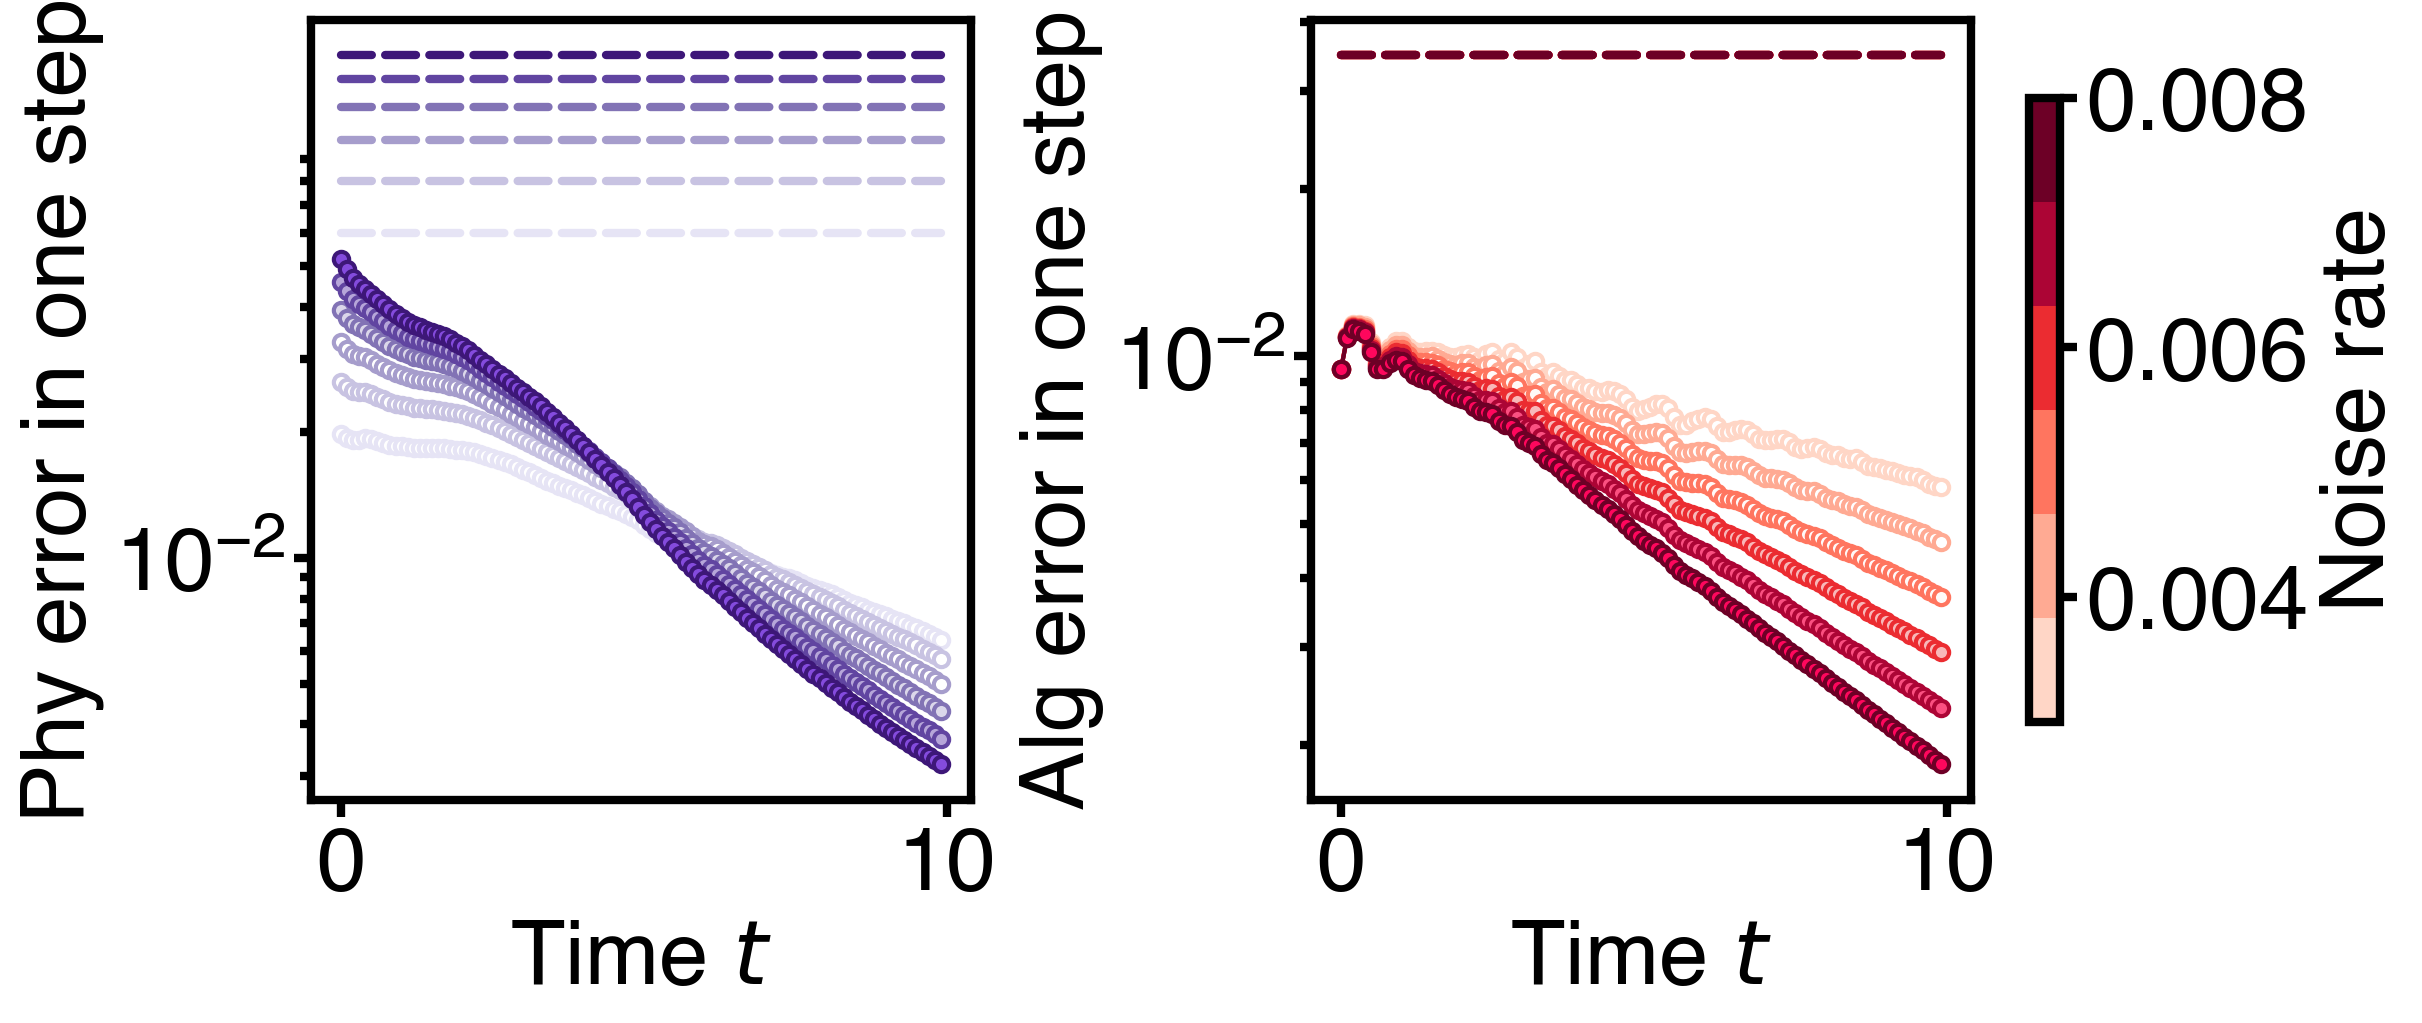

In [9]:
# read the data from the numpy file
H_model = 'nnh'

n = 10
# n = 8
gamma = 5e-3
t, r = n, 100
dt = t/r
t_list = np.arange(0, r)  * dt

data = np.load(f'{data_dir}/{H_model}_depo_decay_n={n}_t={t}_r={r}_gamma={gamma_min}-{gamma_max}.npy', allow_pickle=True).item()

set_fontsize(medium=MEDIUM_SIZE+8, large=LARGE_SIZE+8, linewidth=3.0)
gc = GradColors(gamma_num)
cm_phy, cm_alg, cm_tot, cm_acc, cm_pur, cm_ent = gc.purple, gc.red, gc.green, gc.blue, gc.orange, gc.mint

fig, axes = plt.subplot_mosaic(
    """
    AB
    """, constrained_layout=True, sharex=True, figsize=(12, 5))

worst_alg_bnd = tight_bound(H_list, 2, t/r, 1,  verbose=True)

for i, gamma in enumerate(gamma_list):
    plot_evo(axes['A'], t_list, data['phy'][gamma], '.-', label='Phy error', c=cm_phy(i), ylabel='Phy error in one step', xlabel='Time')  # data[p].phy_err_list
    plot_evo(axes['B'], t_list, data['alg'][gamma], '.-', label='Alg error', c=cm_alg(i), ylabel='Alg error in one step', xlabel='Time')

    worst_phy_bnd = 2 * n * gamma
    plot_evo(axes['A'], t_list, [worst_phy_bnd]*len(t_list), '--', label='Phy error (worst bound)', c=cm_phy(i), ylabel='Phy error in one step', xlabel=rf'Time $t$', lw=3)  # data[p].phy_err_list
    plot_evo(axes['B'], t_list, [worst_alg_bnd]*len(t_list), '--', label='Alg error (worst bound)', c=cm_alg(i), ylabel='Alg error in one step', xlabel=rf'Time $t$', lw=3)  # data[p].phy_err_list

axes['A'].set_yscale('log'); axes['B'].set_yscale('log'); 
axes['A'].set_yticks([1e-2]); axes['B'].set_yticks([1e-2])
for ax in [axes['A'], axes['B']]:
    ax.yaxis.set_minor_formatter(plt.NullFormatter())
cm_normalizer = plt.Normalize(vmin=gamma_list[0], vmax=gamma_list[-1])
plt.colorbar(plt.cm.ScalarMappable(cmap=cm_alg, norm=cm_normalizer), ax=axes['B'], label='Noise rate', shrink=0.8)
# letter_annotation(axes, -.2, 1.0, ['A', 'B', 'C', 'D'], fontsize=26)
prefix, suffix = H_model, 'ErrVSt_fixdt'
fig.savefig(f'{fig_dir}/{prefix}_{suffix}_n={n}_dt={dt}_t={t}_r={r}.pdf')

## Other noise channels

<!-- - global depolarizing -->
- local depolarizing
- local dephasing
- local amplitude damping

In [66]:
from evolution import Evolve_ob, Evolve_state
from qiskit.quantum_info import SparsePauliOp, Statevector

from quantum_simulation_recipe.trotter import pf, expH
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
import numpy as np

model = 'nnh'
n = 10
p_pf = 2
t, r = n, 100
# t, r = 2*n, 100
dt = t/r
t_list = np.arange(0, r) * dt

# p_num = 2
gamma_num = 6
gamma_min, gamma_max = 0.003, 0.008
gamma_list = np.linspace(gamma_min, gamma_max, num=gamma_num)

H_list = []

J, h, pbc = 2, 1, True
model_par = {'Jz': J, 'hx': h, 'pbc': pbc}
nnh = Nearest_Neighbour_1d(n, Jz=J, hx=h, pbc=pbc)
# H_list = [term.to_matrix() for term in nnh.ham_par]
H_list = [term.to_matrix() for term in nnh.ham_xyz]

U_dt = pf(H_list, dt, 1, order=p_pf)
U_dt_exact = expH(sum(H_list), dt)

state_0 = Statevector.from_label('0'*n).to_operator().to_matrix()

# initialize a dictionary to store the results
phy_errs_depo, alg_errs_depo = {}, {}
# phy_errs_glob, alg_errs_glob = {}, {}
phy_errs_deph, alg_errs_deph = {}, {}
phy_errs_damp, alg_errs_damp = {}, {}

for i, gamma in enumerate(gamma_list):
    print(f'noise rate: {gamma:.4f}')
    n_pf_local_depo = Evolve_state(U_dt, U_dt_exact, r, state_0, gamma, p_pf, t, noise_type='local_depolar')
    n_pf_local_deph = Evolve_state(U_dt, U_dt_exact, r, state_0, gamma, p_pf, t, noise_type='local_dephase')
    n_pf_local_damp = Evolve_state(U_dt, U_dt_exact, r, state_0, gamma, p_pf, t, noise_type='local_ampdamp')
    # n_pf_local_depo = Evolve_state(U_dt, U_dt_exact, r, state_0, True, p, noise_type='local_depolar')
    # store the results in the dictionary
    # data[p] = n_pf
    phy_errs_depo[gamma], alg_errs_depo[gamma] = n_pf_local_depo.phy_err_list, n_pf_local_depo.alg_err_list
    phy_errs_deph[gamma], alg_errs_deph[gamma] = n_pf_local_deph.phy_err_list, n_pf_local_deph.alg_err_list
    phy_errs_damp[gamma], alg_errs_damp[gamma] = n_pf_local_damp.phy_err_list, n_pf_local_damp.alg_err_list
    print('depo: ', phy_errs_depo[gamma])
    print('deph: ', phy_errs_deph[gamma])
    print('damp: ', phy_errs_damp[gamma])

data = {'phy_deph': phy_errs_deph, 'alg_deph': alg_errs_deph, 'phy_depo': phy_errs_depo, 'alg_depo': alg_errs_depo, 'phy_damp': phy_errs_damp, 'alg_damp': alg_errs_damp, 'model_par': model_par}
np.save(f'{data_dir}/{model}_depo_deph_damp_decay_n={n}_t={t}_r={r}_gamma{gamma_min}_{gamma_max}.npy', data)
# On my M3 Macbook pro, for n=10, it takes 10mins for one noise channel and one noise rate. (n=8, 30secs)

noise rate: 0.0030
depo:  [0.019822280278772038, 0.019425098554785757, 0.019196102839190224, 0.019222048994299995, 0.019332963617141055, 0.019280714189761836, 0.019080552871594388, 0.018847858635133188, 0.018660489845191787, 0.018556799672568083, 0.018504154711123783, 0.018430514073936477, 0.01836300802101002, 0.018337040698348732, 0.018343127396420862, 0.01835900297284051, 0.01835130322439667, 0.01830577955892459, 0.01824190748262193, 0.018178299061213602, 0.01811174892724567, 0.018023716816573603, 0.01789980638455808, 0.01774327376838491, 0.017567902243250375, 0.017384053952270436, 0.01719671692928233, 0.016997459801637308, 0.016766691077009215, 0.016511266155346992, 0.016266155398398506, 0.016042730850298385, 0.0158178195785689, 0.015573630306380462, 0.015329125026981938, 0.015112375800045739, 0.01491611562999139, 0.014717367329445378, 0.014520799505931924, 0.014327793601127315, 0.014129828072301908, 0.013927082062275054, 0.01371953934306057, 0.013508318345437396, 0.0133079046355136

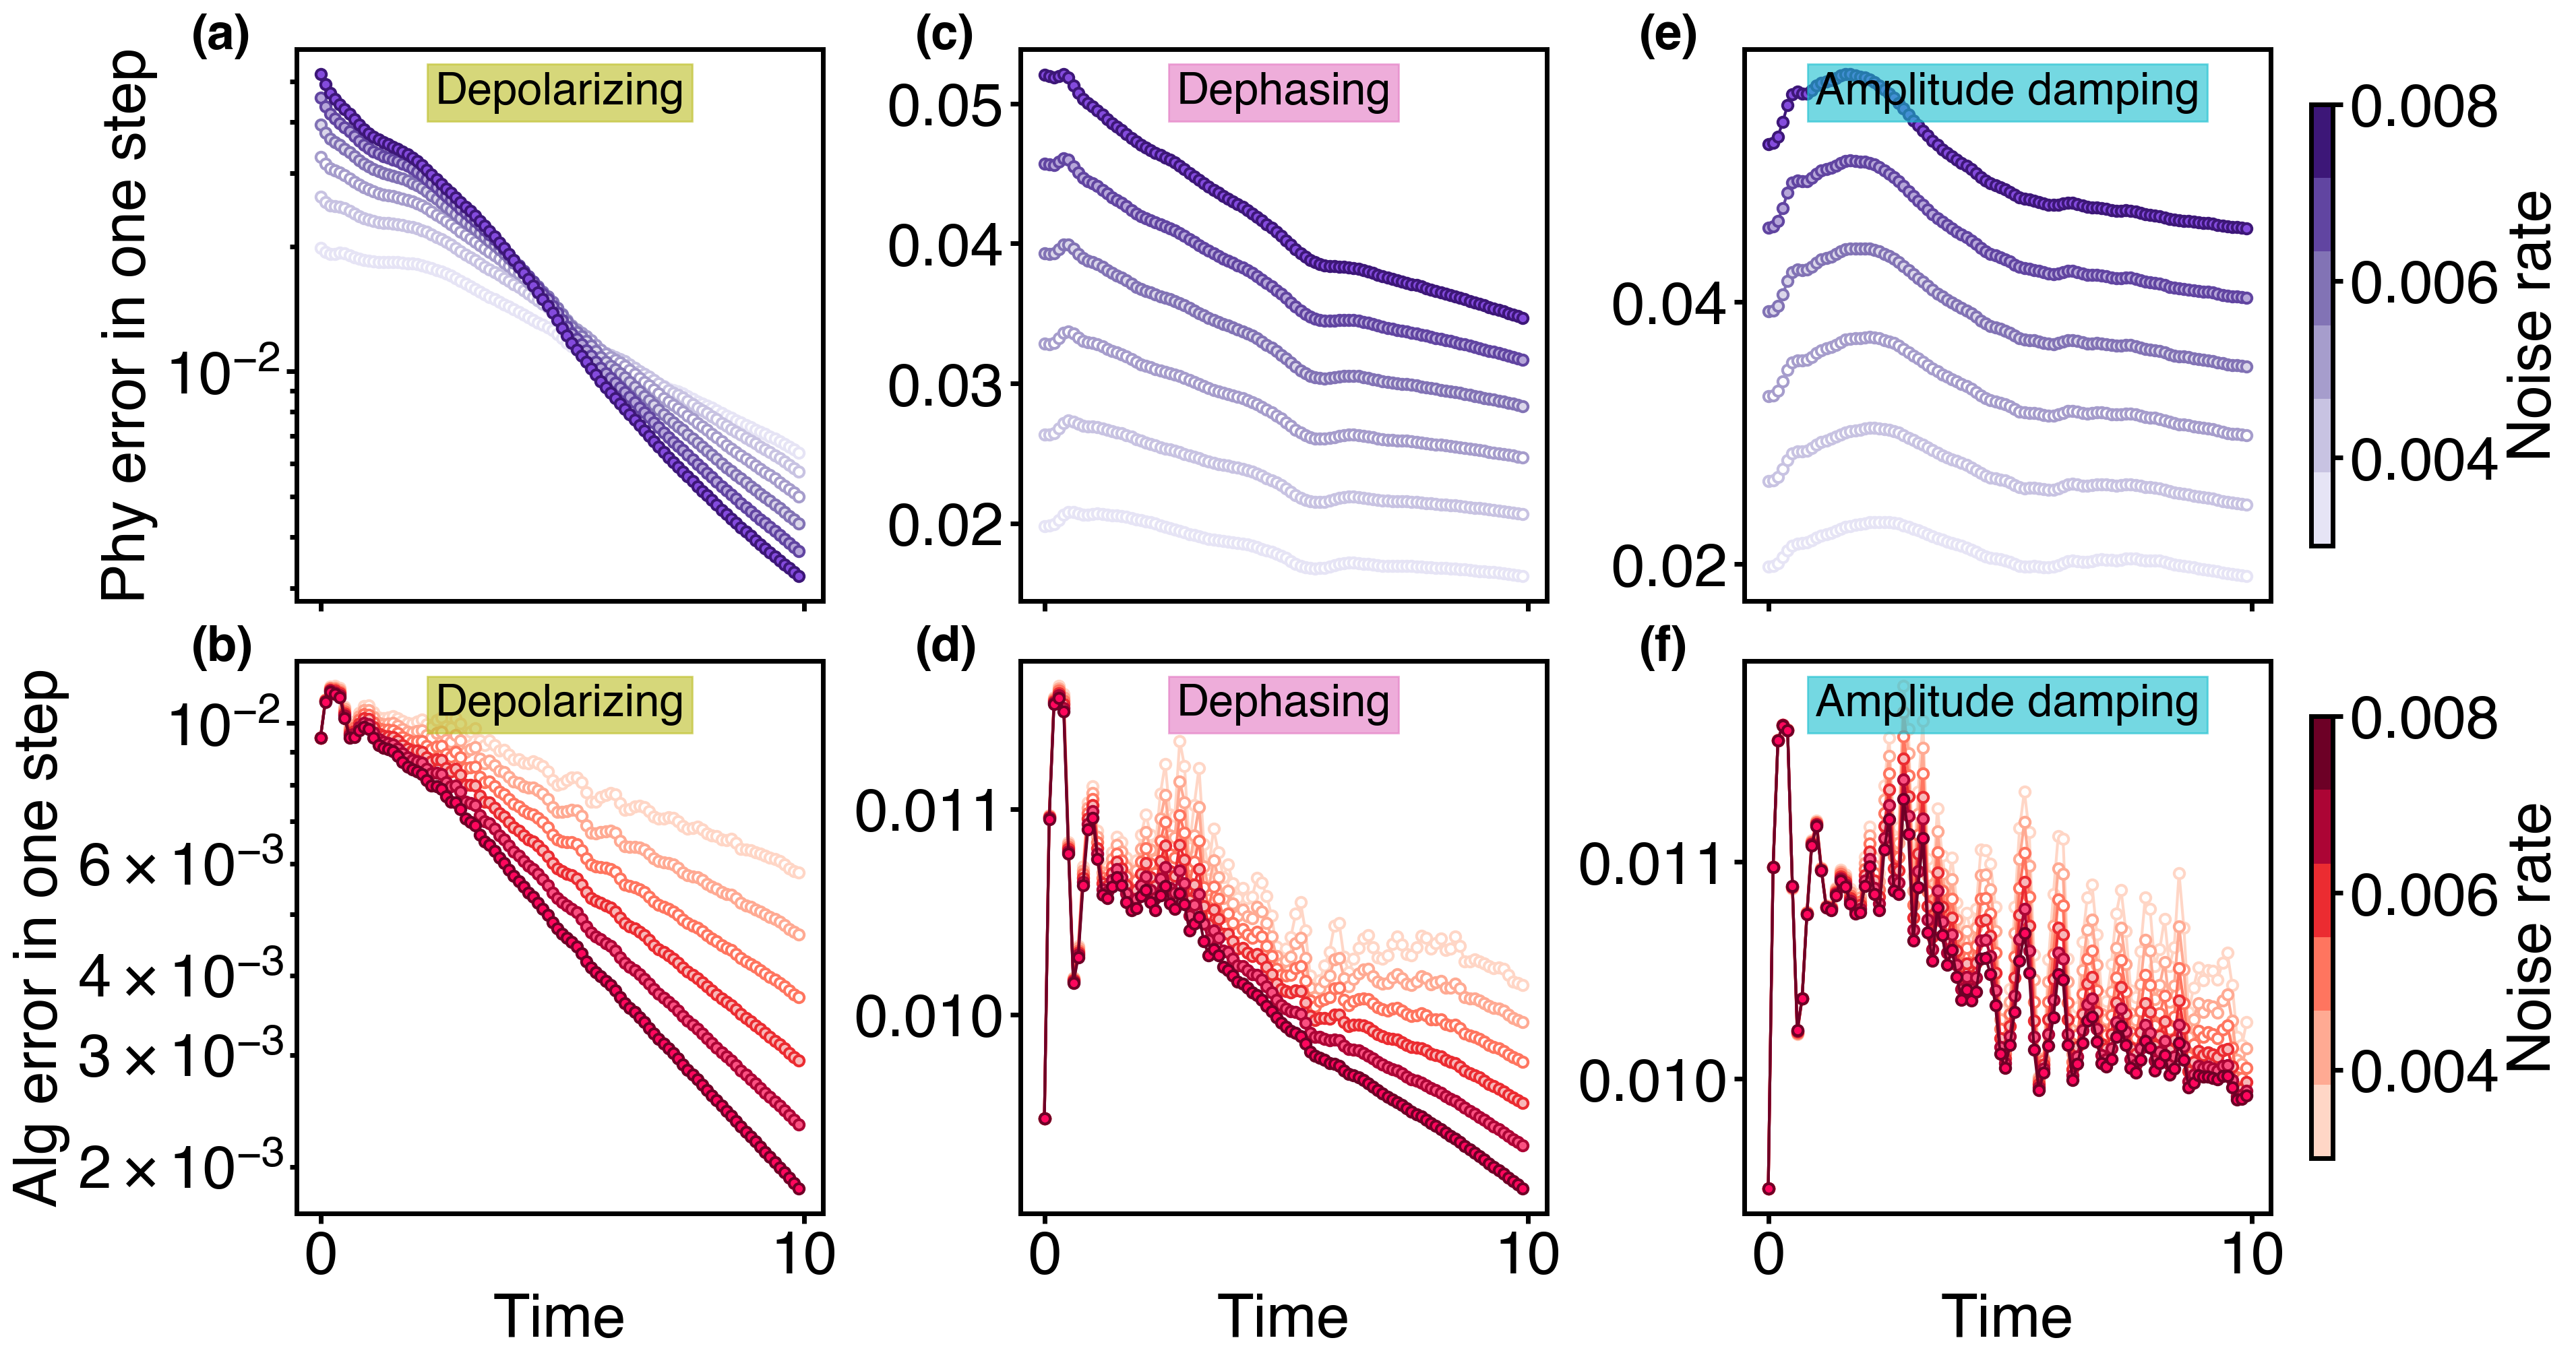

In [18]:
import numpy as np
model = 'nnh'
n = 10
p_pf = 2
t, r = n, 100
# t, r = 2*n, 100
dt = t/r
t_list = np.arange(0, r) * dt

# p_num = 2
gamma_num = 6
gamma_min, gamma_max = 0.003, 0.008
gamma_list = np.linspace(gamma_min, gamma_max, num=gamma_num)

# read the data from the numpy file
data = np.load(f'{data_dir}/{model}_depo_deph_damp_decay_n={n}_t={t}_r={r}_gamma{gamma_min}_{gamma_max}.npy', allow_pickle=True).item()

set_fontsize(medium=MEDIUM_SIZE+8, large=LARGE_SIZE+8, linewidth=2.5)
gc = GradColors(gamma_num)
cm_phy, cm_alg, cm_tot, cm_acc, cm_pur, cm_ent = gc.purple, gc.red, gc.green, gc.blue, gc.orange, gc.mint

fig, axes = plt.subplot_mosaic(
    """
    ACE
    BDF
    """, constrained_layout=True, sharex=True, figsize=(19, 10))
    # """, constrained_layout=True, sharex=True, figsize=(16, 14))

for i, gamma in enumerate(gamma_list):
    plot_evo(axes['A'], t_list, data['phy_depo'][gamma], '.-', label='Phy error', c=cm_phy(i), ylabel='Phy error in one step')  # data[p].phy_err_list
    plot_evo(axes['B'], t_list, data['alg_depo'][gamma], '.-', label='Alg error', c=cm_alg(i), ylabel='Alg error in one step', xlabel='Time')
    plot_evo(axes['C'], t_list, data['phy_deph'][gamma], '.-', label='Phy error', c=cm_phy(i))  # data[p].phy_err_list
    plot_evo(axes['D'], t_list, data['alg_deph'][gamma], '.-', label='Alg error', c=cm_alg(i), xlabel='Time')
    plot_evo(axes['E'], t_list, data['phy_damp'][gamma], '.-', label='Phy error', c=cm_phy(i))  # data[p].phy_err_list
    plot_evo(axes['F'], t_list, data['alg_damp'][gamma], '.-', label='Alg error', c=cm_alg(i), xlabel='Time')
# bbox_props = dict(facecolor='w', alpha=1, edgecolor='w')
bbox_props_depo = dict(facecolor='#bcbd22FF', alpha=.6, edgecolor='#bcbd22FF')
bbox_props_deph = dict(facecolor='#e377c2FF', alpha=.6, edgecolor='#e377c2FF')
bbox_props_damp = dict(facecolor='#17becfFF', alpha=.6, edgecolor='#17becfFF')
axes['A'].annotate('Depolarizing', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_depo)
axes['B'].annotate('Depolarizing', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_depo)
axes['C'].annotate('Dephasing', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_deph)
axes['D'].annotate('Dephasing', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_deph)
axes['E'].annotate('Amplitude damping', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_damp)
axes['F'].annotate('Amplitude damping', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=24, ha='center', bbox=bbox_props_damp)

axes['A'].set_yscale('log'); axes['B'].set_yscale('log'); 
cm_normalizer = plt.Normalize(vmin=gamma_list[0], vmax=gamma_list[-1])
# plt.colorbar(plt.cm.ScalarMappable(cmap=cm_alg, norm=cm_normalizer), ax=axes['B'], label='Noise rate', shrink=0.8)
# plt.colorbar(plt.cm.ScalarMappable(cmap=cm_alg, norm=cm_normalizer), ax=axes['D'], label='Noise rate', shrink=0.8)
plt.colorbar(plt.cm.ScalarMappable(cmap=cm_phy, norm=cm_normalizer), ax=axes['E'], label='Noise rate', shrink=0.8)
plt.colorbar(plt.cm.ScalarMappable(cmap=cm_alg, norm=cm_normalizer), ax=axes['F'], label='Noise rate', shrink=0.8)
letter_annotation(axes, -.2, 1.0, ['A', 'B', 'C', 'D', 'E', 'F'], fontsize=26)
prefix, suffix = 'TFI', 'ErrVSt_fixdt'
fig.savefig(f'{fig_dir}/{prefix}_{suffix}_depo_deph_damp_decay_n={n}_dt={dt}_t={t}_r={r}_row.pdf', bbox_inches='tight')